<div style="text-align: right" align="right"><i>Peter Norvig, 2015–2023</i></div>

# The Traveling Salesperson Problem

Consider the [***Traveling Salesperson Problem***](http://en.wikipedia.org/wiki/Traveling_salesman_problem) (abbreviated ***TSP***): 

- *Given a **set of cities** and the **distance** between each pair of cities, what is the **shortest** possible **tour** that visits each city exactly once, and returns to the starting city?*

In this notebook we will develop some solutions to the problem, and more generally show *how to think about* solving  problems. Versions of the algorithms developed here are used in [serious applications](https://research.googleblog.com/2016/09/the-280-year-old-algorithm-inside.html) that millions of people rely on every day. 

|![](http://support.sas.com/documentation/cdl/en/ornoaug/66084/HTML/default/images/map002g.png)|
|---|
|[An example tour, from the TSP History page](http://www.math.uwaterloo.ca/tsp/history/pictorial/dfj.html)|


# Implementation of Basic Concepts

I'll go through all the  concepts from the definition and make Python implementation choices for each one:

- **Distance:** The straight-line distance between two points in a two-dimensional plane (or between two cities on a map) is called the [**Euclidean distance**](http://en.wikipedia.org/wiki/Euclidean_distance). I'll implement that with a function `distance(A, B)`. This distance measure is **non-negative** and **symmetric** (the distance from `A` to `B` is the same as the distance from `B` to `A`). But not all distance metrics are like this. If you have to follow roads rather than straight lines, the distance is at the whim of the road-builders. Perhaps the distance from `A` to `B` is different than the distance from `B` to `A` because of one-way streets. Or perhaps you are taking plane flights and the total time of going from `A` to `B` to `C` is less than going directly from `A` to `C` (because `B` is a hub with frequent flights). Almost everything in this notebook still holds with a different distance function; I'll  point out where it doesn't.
- **City:** Given the choice of a Euclidean distance function, the only thing we need to know about a city is its position on the (*x*, *y*) plane. We don't need to know the city's name, population, best restaurants, or anything else. I will define `City` so that `City(300, 100)` creates a point with *x*-coordinate 300 and *y*-coordinate 100. 
- **Set of cities:** A set of cities can be represented with a Python set. I'll use [`frozenset`](https://docs.python.org/3/library/stdtypes.html?highlight=frozenset#frozenset), which is a set that can't be changed. 
- **Tour** (also called a **cycle** or **circuit** or [**Hamiltonian path**](https://en.wikipedia.org/wiki/Hamiltonian_path)): A tour that goes from city `A` to `B` to`C` and back to `A` will be represented by the list `[A, B, C]`. 
- **Shortest**: The shortest tour is the one with the smallest total tour length. `shortest(tours)` implements this.
- **Tour length:** The call `tour_length(tour)` gives the sum of the distances between adjacent cities in the tour (including back to the start).
- **Valid Tour:** A tour is valid if it visits every city exactly once and returns to the start; in other words if it is  a *permutation* of the cities.  `valid_tour` implements that.

Three more basic concepts, not explicitly mentioned in the definition:

- **Point:** At first glance, Python does not have a builtin type for a two-dimensional point. But  there is one: [complex numbers](https://docs.python.org/3/c-api/complex.html).  
- **Link**: A tour consists of a sequence of **links** between cities. A link can be represented implicitly by the adjacency of two cities in a tour, or explicitly by an `(A, B)` pair of cities.
- **TSP algorithm**: A function with the signature `tsp(cities: Cities) -> Tour`.

First some imports (don't worry about these; they will be explained later as they are used):

In [26]:
import functools
import itertools
import pathlib
import random
import time  
import math
import re
import matplotlib.pyplot as plt      
from collections import Counter, defaultdict, namedtuple
from statistics  import mean, median, stdev
from typing      import Set, List, Tuple, Iterable, Dict

Now the implementation of the basic concepts:

In [27]:
City   = complex   # e.g. City(300, 100)
Cities = frozenset # A set of cities
Tour   = list      # A list of cities visited, in order
TSP    = callable  # A TSP algorithm is a callable function
Link   = Tuple[City, City] # A city-city link

def distance(A: City, B: City) -> float: 
    "Distance between two cities"
    return abs(A - B)

def shortest(tours: Iterable[Tour]) -> Tour: 
    "The tour with the smallest tour length."
    return min(tours, key=tour_length)

def tour_length(tour: Tour) -> float:
    "The total distances of each link in the tour, including the link from last back to first."
    return sum(distance(tour[i], tour[i - 1]) for i in range(len(tour)))

def valid_tour(tour: Tour, cities: Cities) -> bool:
    "Does `tour` visit every city in `cities` exactly once?"
    return Counter(tour) == Counter(cities)

# Sets of Random Cities

To test TSP algorithms, I'll need sets of cities. I'll define `random_cities(n)` to return a set of `n` cities, sprawled out randomly over the map. 

*Note*: I want to be able to do reproducible comparisons of algorithms: to run two or more algorithms on the same set of cities. Therefore `random_cities` has an optional argument, `seed`, with a default value. If you pass in the same seed, you will get back the same set of cities. This is true even after restarting with a different version of Python (it could possibly change with a major revision, as in Python 2 to Python 3). If you want a different set of *n* random cities, pass in a different seed.

In [28]:
def random_cities(n, seed=1234, width=9999, height=6666) -> Cities:
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed)) # To make `random_cities` reproducible
    return Cities(City(random.randrange(width), random.randrange(height))
                  for c in range(n))

# Exhaustive TSP Search Algorithm: `exhaustive_tsp`

Let's start with an algorithm that is *guaranteed* to find the shortest tour, although inefficiently:

- **Exhaustive TSP Search Algorithm**: *Generate all possible tours of the cities, and choose the shortest one.*

My design philosophy is to first write an English description of the algorithm (as above), then write Python code that closely mirrors the English description. I note that the possible tours of a set of cities are the permutations of the cities. So implementing this algorithm is easy. I note that the possible tours of a set of cities are just the permutations of the city, and `permutations` is defined in the `itertools` module, so we get:

In [29]:
possible_tours = itertools.permutations 

def exhaustive_tsp(cities) -> Tour:
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(possible_tours(cities))



Let's try it on a random set of 8 cities:

In [30]:
exhaustive_tsp(random_cities(8))

/var/folders/ny/b0tz42v157sfljpqck8jlcy40000gn/T/ipykernel_47026/912097865.py:3: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed((n, seed)) # To make `random_cities` reproducible


((4698+4764j),
 (2301+3350j),
 (1276+3305j),
 (4215+1920j),
 (8883+324j),
 (9744+950j),
 (8315+4692j),
 (9081+6286j))

Quick, is that the shortest tour?  I can't tell, and I bet you can't either. But if I plotted the points on a map, maybe we would be enlightened.

# Visualizing results: `plot_tour`

I'll define `plot_tour` to plot all the cities and links in a tour, highlighting the first city. 

- *Vocabulary note:* A **segment** is a portion of a tour that does not loop back to the start. The **segment** `[A, B, C]` has only two links, A-B and B-C, whereas the **tour** `[A, B, C]` has three links, A-B, B-C, and C-A.

In [31]:
Segment = list # A portion of a tour; it does not loop back to the start.

def plot_tour(tour: Tour, style='bo-', hilite='rs', title=''): 
    "Plot every city and link in the tour, and highlight the start city."
    scale = 1 + len(tour) ** 0.5 // 10
    plt.figure(figsize=((3 * scale, 2 * scale)))
    start = tour[0]
    plot_segment([*tour, start], style)
    plot_segment([start], hilite) 
    plt.title(title)
    
def Xs(cities) -> List[float]: "X coordinates"; return [c.real for c in cities]
def Ys(cities) -> List[float]: "Y coordinates"; return [c.imag for c in cities]

def plot_segment(segment: Segment, style='bo:'):
    "Plot every city and link in the segment."
    plt.plot(Xs(segment), Ys(segment), style, linewidth=2/3, markersize=4, clip_on=False)
    plt.axis('scaled'); plt.axis('off')

/var/folders/ny/b0tz42v157sfljpqck8jlcy40000gn/T/ipykernel_47026/912097865.py:3: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed((n, seed)) # To make `random_cities` reproducible


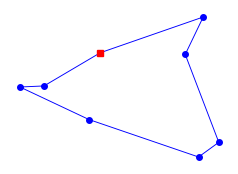

In [32]:
plot_tour(exhaustive_tsp(random_cities(8)))

The plot helps convince me that this is indeed the shortest tour.

# Convenience function: `run`

I will define `run` to run a TSP algorithm on a set of cities, plot the resulting tour, and print the tour length and run time.

In [33]:
def run(tsp: callable, cities: Cities):
    """Run a TSP algorithm on a set of cities and plot/print results."""
    t0   = time.perf_counter()
    tour = tsp(cities)
    t1   = time.perf_counter()
    L    = tour_length(tour)
    print(f"length {round(L):,d} tour of {len(cities)} cities in {t1 - t0:.3f} secs")
    plot_tour(tour)

Here is `run` in action:

/var/folders/ny/b0tz42v157sfljpqck8jlcy40000gn/T/ipykernel_47026/912097865.py:3: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed((n, seed)) # To make `random_cities` reproducible


length 23,470 tour of 8 cities in 0.058 secs


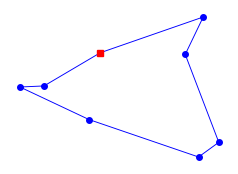

In [34]:
run(exhaustive_tsp, random_cities(8))

# General Strategies for Algorithm Design

It takes Exhaustive Search a second or so to solve a 10-city problem, so 12 cities would take about 2 minutes (11×12 times longer), and 15 cities would take days. 
There must be a better way ... 

To get inspired, here are some general  strategies for algorithm design: 

* **Brute Force Strategy**: The strategy used for `exhaustive_tsp`; as [Ken Thompson](https://en.wikipedia.org/wiki/Ken_Thompson) [says](https://www.brainyquote.com/quotes/ken_thompson_185574?src=t_brute_force), "*when in doubt, use brute force*."
* **Approximation Strategy**: If it is too hard to find an exact, optimal solution, consider an approximate, slightly suboptimal solution.
* **Greeedy Strategy**: To complete a multiple step problem, first do the step that appears to be best in the short run. Repeat. 
* **Improvement Strategy**: Use an existing algorithm to create a solution, then have another algorithm improve the solution.
* **Divide and Conquer Strategy**: Split the problem in half, solve each half, and combine the two partial solutions.
* **Ensemble Strategy**: Apply a set of algorithms to the problem, and pick the best solution. 
* **Stand on the Shoulders of Giants Strategy**: Find out what other people have done, and copy them.


# Real Cities

A tour of 3,000 random cities may look like a [Jackson Pollack](https://www.moma.org/artists/4675) painting, but I thought it would be fun to work on some *real* cities. I found a web page (now 404, but a copy is [here](https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm)) that lists coordinates of over 1000 cities in the USA (actually, the locations of airports in these cities), in this format:

     [TCL]  33.23   87.62  Tuscaloosa,AL
     [FLG]  35.13  111.67  Flagstaff,AZ
     [ANC]  61.17  150.02  Anchorage,AK

We can fetch the file if a local copy is not already in the current directory:

In [35]:
! [ -e latlong.htm ] || curl -O https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm

I define the function `parse_cities` to extract cities from a file in this format (skipping Alaska and Hawaii):

length 1,122,001 tour of 1088 cities in 0.000 secs


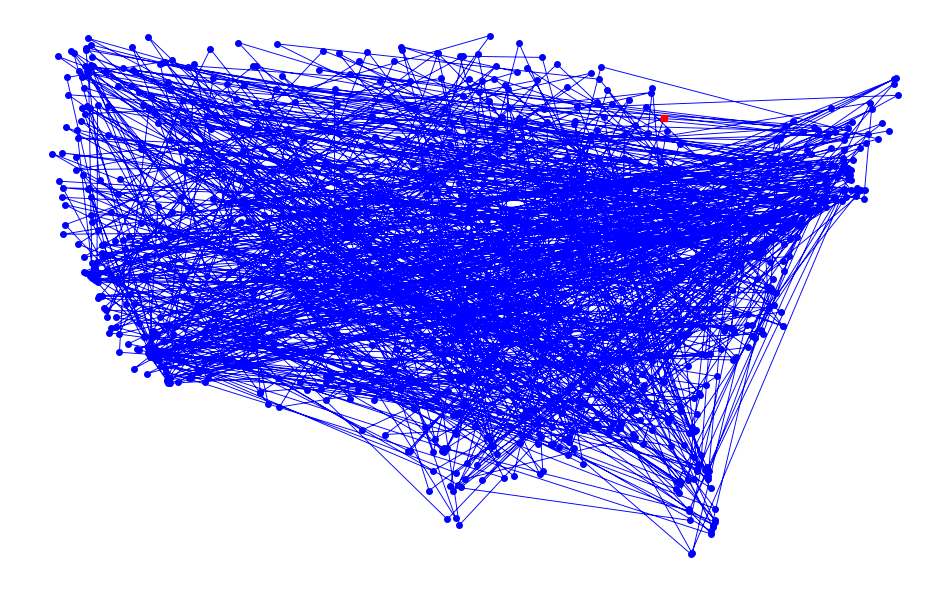

In [36]:
def parse_cities(text, skip=('AK', 'HI'), long_scale=-48, lat_scale=69) -> Cities:
    """Make a set of Cities from lines of text, skipping the specified states."""
    return Cities(City(int(long_scale * float(long)), int(lat_scale  * float(lat)))
                  for (lat, long, state) in re.findall(r'([\d.]+)\s+([\d.]+).+([A-Z][A-Z])', text)
                  if state not in skip)

USA = parse_cities(pathlib.Path('latlong.htm').read_text())


def naive_tsp(cities):
    tour = [city for city in cities]
    return tour

run(naive_tsp, USA)

length 45,289 tour of 1088 cities in 179.108 secs


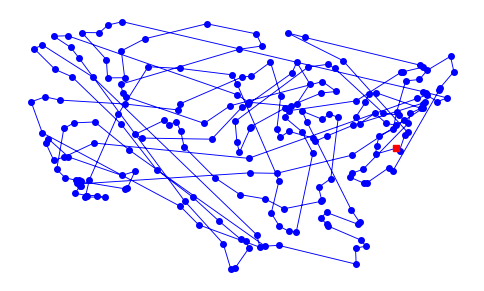

In [48]:
# write your code in here

def local_search_tsp(cities): # 2 opt
    """need you to implement a local search for TSP"""
    tour = []
    for idx, city in enumerate(cities):
        if idx % 5 == 0:
            tour.append(city)# if idx % 5 == 0]
    last_tour_len = tour_length(tour)
    while 1:
        cur_tour = tour
        cur_tour_len = tour_length(cur_tour)
        for i in range(len(tour)):
            for j in range(i + 1, len(tour)):
                new_tour = tour[:]
                new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
                new_tour_len = tour_length(new_tour)
                if new_tour_len < cur_tour_len:
                    cur_tour_len = new_tour_len
                    cur_tour = new_tour
        tour = cur_tour
        if last_tour_len - cur_tour_len < 1:
            break
        last_tour_len = cur_tour_len
        
        
    #print(len(tour))
    return tour


run(local_search_tsp, USA)

50806.89479667554
44478.242378602015
39079.86567568488
34620.34527880435
31248.822443232755
29238.148681564297
27212.95800661639
24043.598620887075
22982.69542445531
22044.2841815722
21219.49130310203
20610.787930108345
20234.400495498143
19941.16857168609
19437.632444017596
19165.887749769943
18896.031095118306
18013.934035334147
17705.89264083835
17387.59737507645
17151.2448055519
16763.669284089858
16518.669439037396
16296.920218163807
16102.574876523455
15911.010023840603
15648.520700770061
15471.526156318805
15317.310700689293
15177.790185576716
15109.701021896282
15066.491359603642
14908.353442948217
14847.332718142821
14711.231941826118
14668.227112545956
14636.650725175734
14605.355776123886
14576.396145360266
14448.420389620607
14391.303185515448
14341.621535621247
14164.921005560149
13887.233278790147
13808.680695200079
13733.16771276633
length 13,733 tour of 1088 cities in 16.256 secs


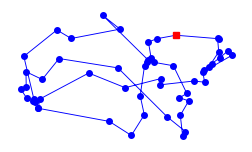

In [57]:
# write your code in here

def local_search_tsp(cities): # 3 opt
    """need you to implement a local search for TSP"""
    tour = []
    for idx, city in enumerate(cities):
        if idx % 20 == 0:
            tour.append(city)# if idx % 5 == 0]
    last_tour_len = tour_length(tour)
    while 1:
        cur_tour = tour
        cur_tour_len = tour_length(cur_tour)
        for i in range(len(tour)):
            for j in range(i + 1, len(tour)):
                for k in range(j + 1, len(tour)):
                    new_tour = tour[:]
                    new_tour[i], new_tour[j], new_tour[k] = new_tour[j], new_tour[k], new_tour[i]
                    new_tour_len = tour_length(new_tour)
                    if new_tour_len < cur_tour_len:
                        cur_tour_len = new_tour_len
                        cur_tour = new_tour
                        
                    new_tour = tour[:]
                    new_tour[i], new_tour[j], new_tour[k] = new_tour[k], new_tour[i], new_tour[j]
                    new_tour_len = tour_length(new_tour)
                    if new_tour_len < cur_tour_len:
                        cur_tour_len = new_tour_len
                        cur_tour = new_tour
        tour = cur_tour
        if last_tour_len - cur_tour_len < 1:
            break
        last_tour_len = cur_tour_len
        print(cur_tour_len)
        
        
    #print(len(tour))
    return tour


run(local_search_tsp, USA)

length 21,634 tour of 1088 cities in 139.105 secs


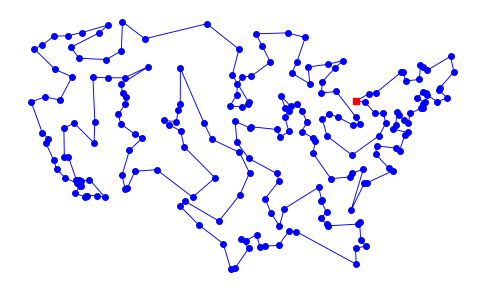

In [54]:
# write your code in here

def local_search_tsp(cities): # 3 opt
    """need you to implement a local search for TSP"""
    tour = []
    for idx, city in enumerate(cities):
        if idx % 5 == 0:
            tour.append(city)# if idx % 5 == 0]
    last_tour_len = tour_length(tour)
    while 1:
        cur_tour = tour
        cur_tour_len = tour_length(cur_tour)
        for i in range(len(tour)):
            for j in range(i + 2, len(tour)):
                    new_tour = tour[:]
                    new_tour[i:j] = new_tour[i:j][::-1]
                    new_tour_len = tour_length(new_tour)
                    if new_tour_len < cur_tour_len:
                        cur_tour_len = new_tour_len
                        cur_tour = new_tour
        tour = cur_tour
        if last_tour_len - cur_tour_len < 1:
            break
        last_tour_len = cur_tour_len
        
        
    #print(len(tour))
    return tour


run(local_search_tsp, USA)